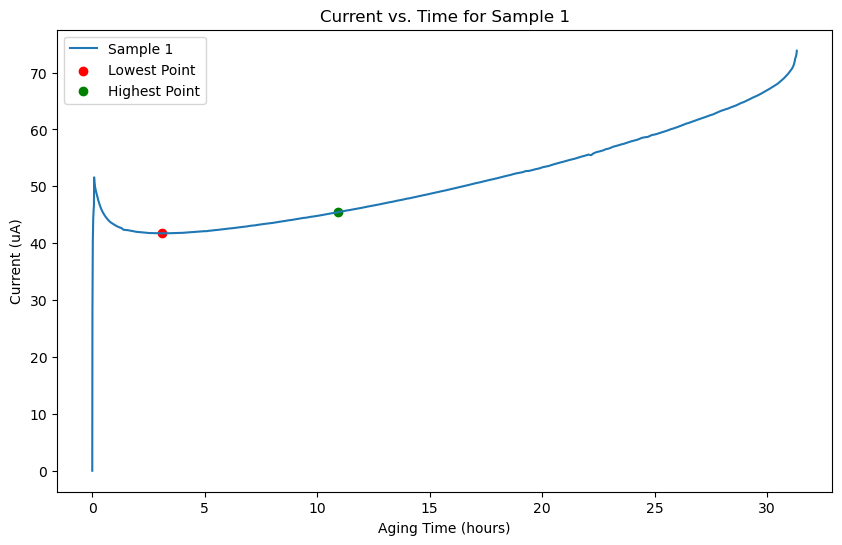

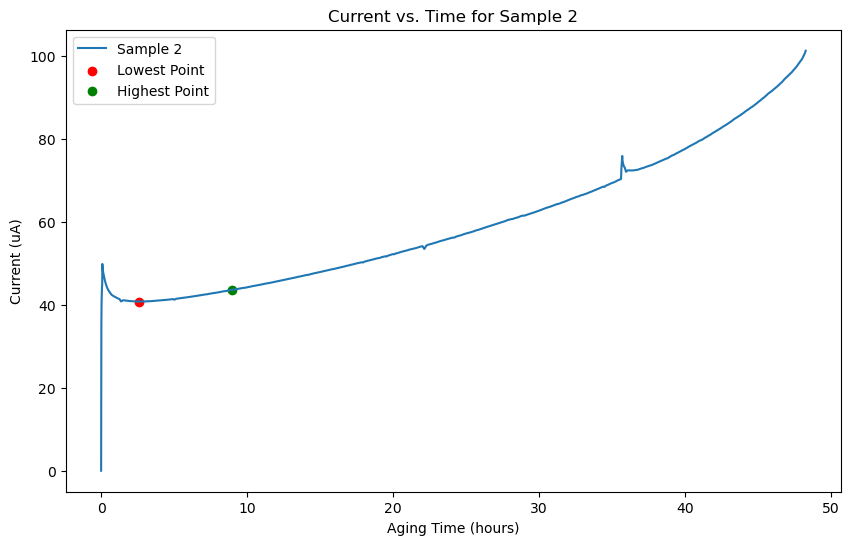

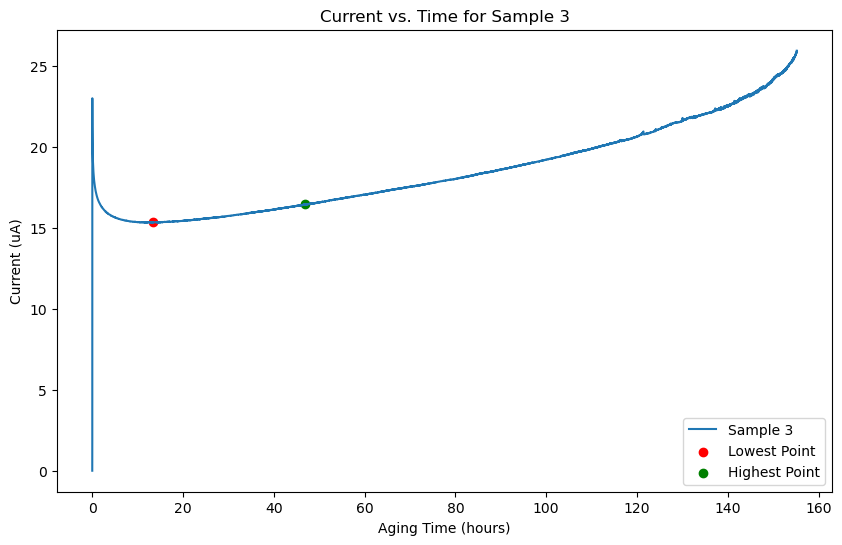

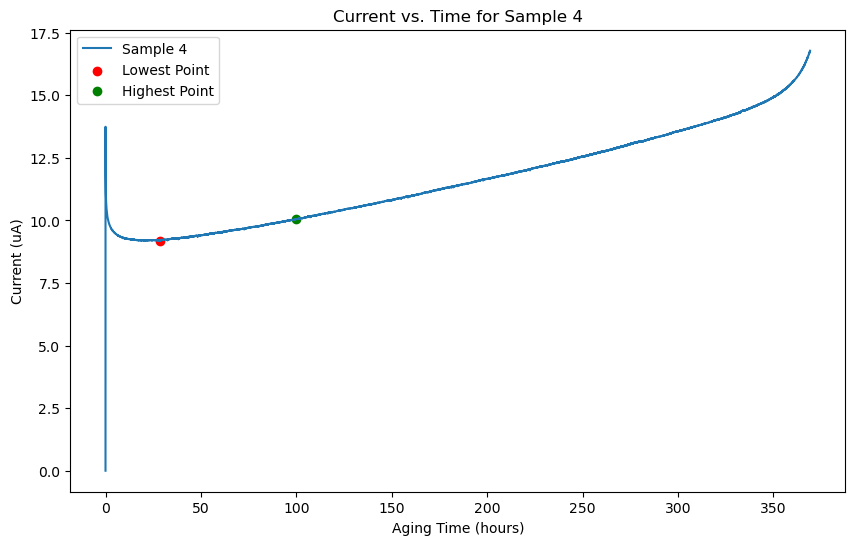

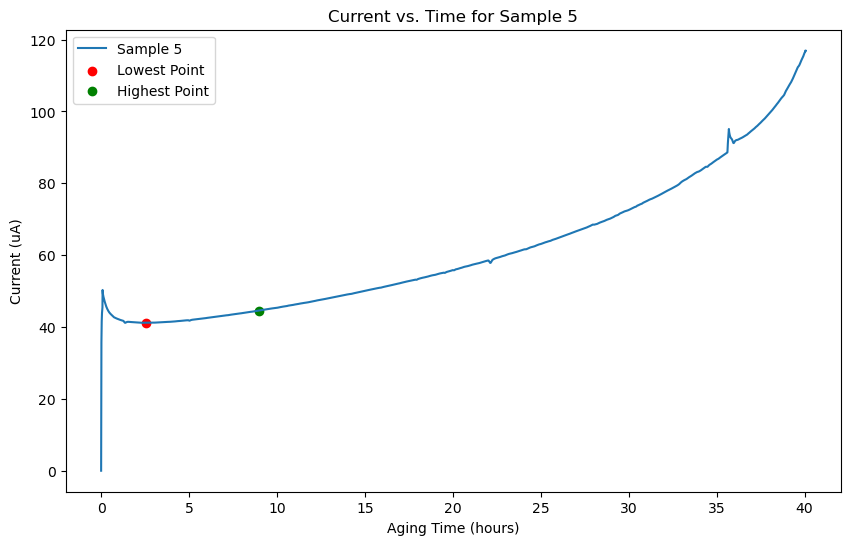

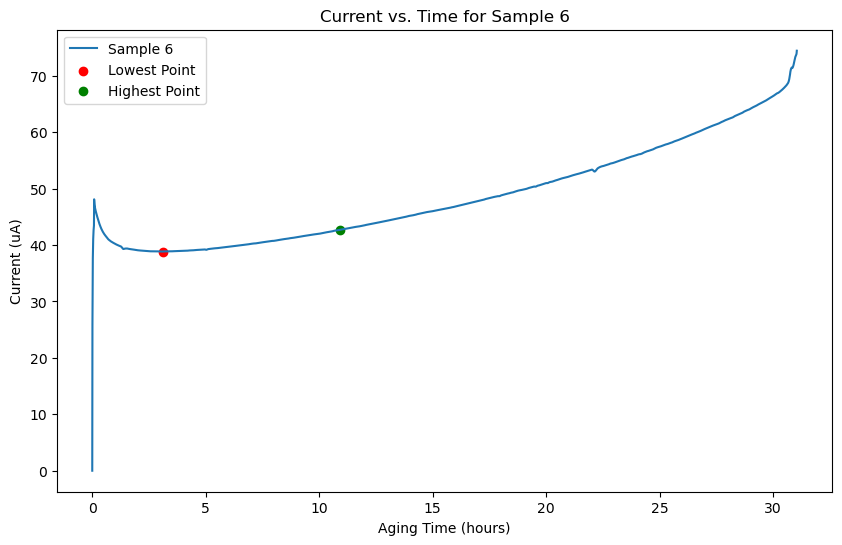

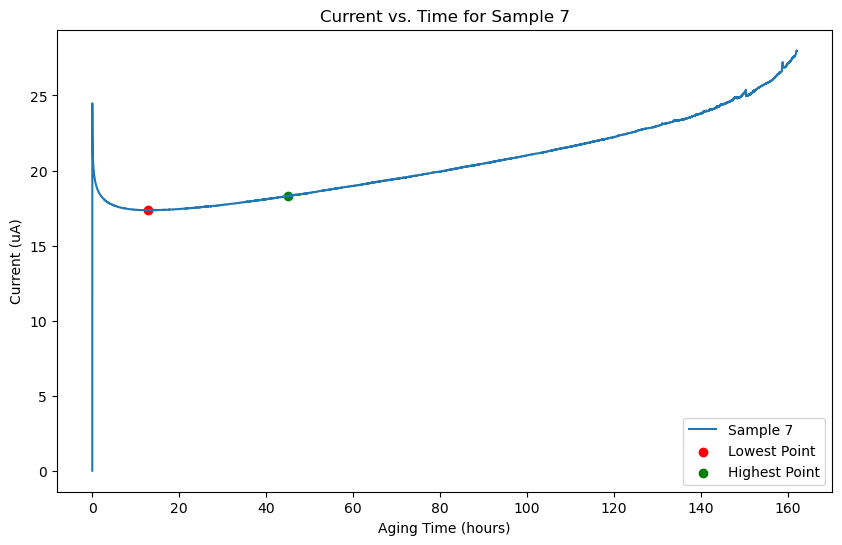

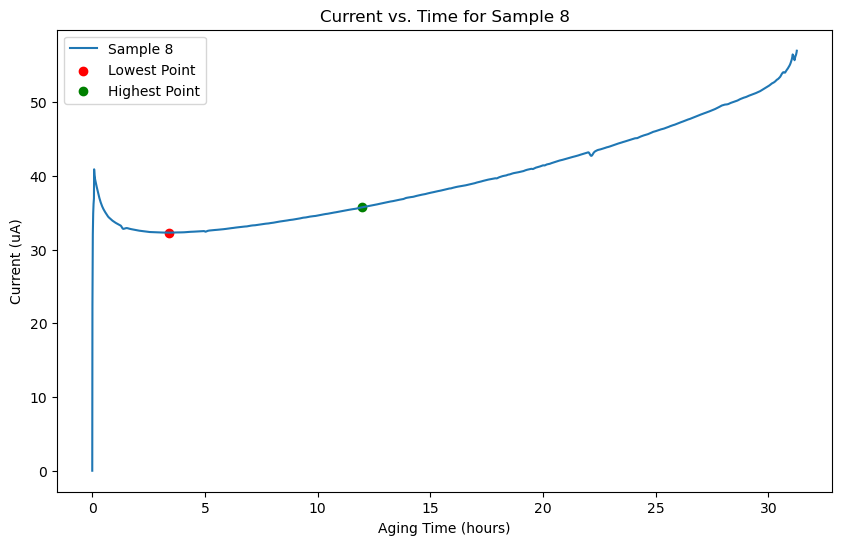

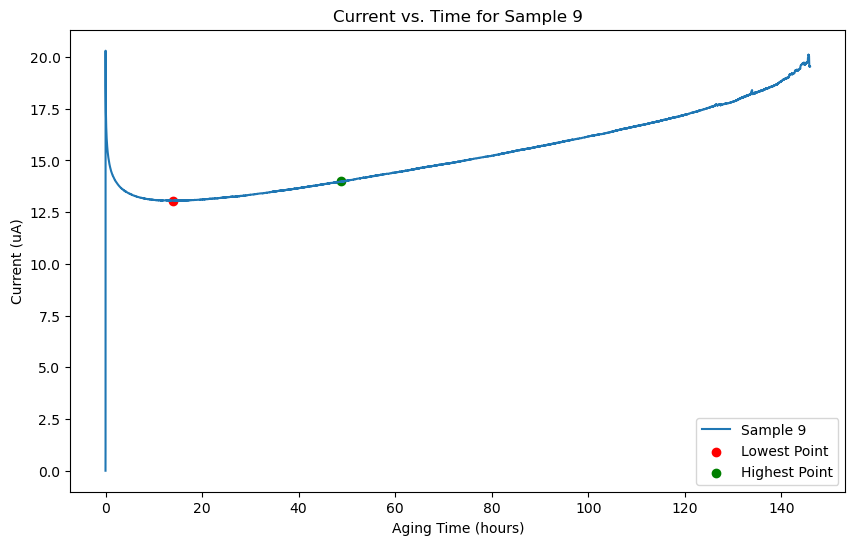

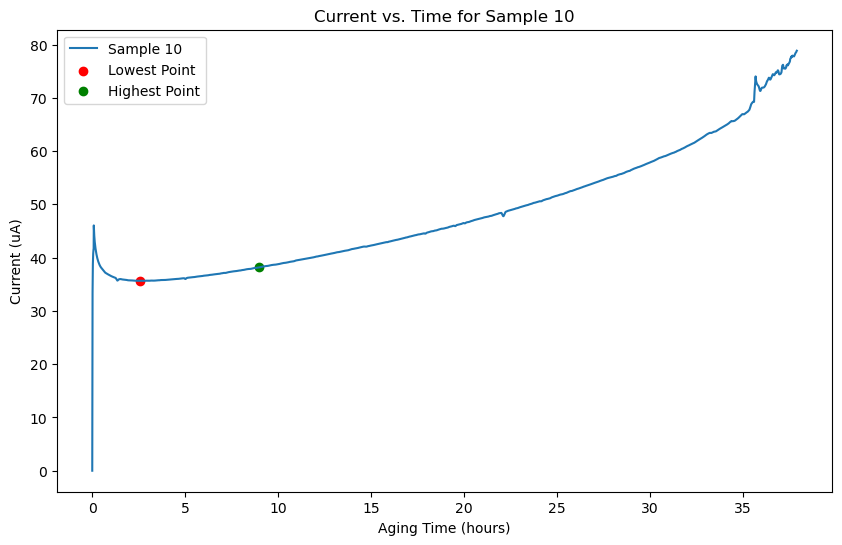

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import matplotlib.pyplot as plt
import random

def calculate_features(df, slope_multiplier, lowest_point_range, time_interval):
    result_df = pd.DataFrame(columns=['I1', 'k', 't1', 'I2', 't2', 'ttf'])
    all_points = []

    for column in df.columns:  # 遍历每一列（假设所有列都是电流数据）
        current_data = df[column].dropna().reset_index(drop=True)

        # 生成时间列，并转换为小时
        aging_time = np.arange(len(current_data)) * time_interval
        current_data = pd.DataFrame({'老化时间': aging_time, column: current_data})

        # 在第10到lowest_point_range个数据点中寻找连续5个值的平均值最小的点
        limited_current_data = current_data[9:lowest_point_range]
        rolling_means = limited_current_data[column].rolling(window=5).mean().dropna()
        min_mean_idx = rolling_means.idxmin() if not rolling_means.empty else None

        if min_mean_idx is not None and min_mean_idx in limited_current_data.index:
            # 使用连续5个值的平均值最小的点作为最低点
            min_mean_idx = int(min_mean_idx)
            t1 = current_data.at[min_mean_idx + 2, '老化时间']  # 使用5个点中的中间点
            I1 = current_data.at[min_mean_idx + 2, column]
            ttf = current_data['老化时间'].max()

            # 确定观察时间段
            end_time_point = t1 * slope_multiplier
            observation_period = current_data[(current_data['老化时间'] > t1) & (current_data['老化时间'] <= end_time_point)]

            if len(observation_period) >= 2:
                # 准备线性回归的输入数据
                X = observation_period[['老化时间']].values.reshape(-1, 1)
                y = observation_period[column].values

                # 使用线性回归模型计算电流上升斜率
                model = LinearRegression()
                model.fit(X, y)
                k = model.coef_[0]  # 提取斜率

                # 找到观察时间段内的最高点
                highest_point_idx = observation_period[column].idxmax()
                I2 = observation_period.at[highest_point_idx, column]
                t2 = observation_period.at[highest_point_idx, '老化时间']
            else:
                k = np.nan  # 数据点不足，斜率设为 NaN
                I2 = np.nan
                t2 = np.nan

            new_row = pd.DataFrame({
                'I1': [I1],
                'k': [k],
                't1': [t1],
                'I2': [I2],
                't2': [t2],
                'ttf': [ttf]
            })
            result_df = pd.concat([result_df, new_row], ignore_index=True)
            all_points.append((current_data, t1, I1, t2, I2))

    return result_df, all_points


def plot_curves(all_points, num_samples=10):
    if len(all_points) > num_samples:
        all_points = random.sample(all_points, num_samples)

    for i, (current_data, t1, I1, t2, I2) in enumerate(all_points):
        plt.figure(figsize=(10, 6))
        plt.plot(current_data['老化时间'], current_data.iloc[:, 1], label=f'Sample {i + 1}')
        plt.scatter(t1, I1, color='red', label='Lowest Point')
        plt.scatter(t2, I2, color='green', label='Highest Point')
        plt.xlabel('Aging Time (hours)')
        plt.ylabel('Current (uA)')
        plt.title(f'Current vs. Time for Sample {i + 1}')
        plt.legend()
        plt.show()


# 从Excel文件中读取数据
df = pd.read_excel('time_series.xlsx')

# 设置参数
lowest_point_range = 20000
time_interval = 30 / 3600
best_slope_multiplier=3.5


# 使用最佳的 slope_multiplier 计算特征
features_df, all_points = calculate_features(df, best_slope_multiplier, lowest_point_range, time_interval)

# 输出特征数据到Excel文件
features_df.to_csv('current_feature_best_slope_multiplier.csv', index=False)

# 可视化电流曲线
plot_curves(all_points)
